In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Train

In [2]:
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.layers import TimeDistributed, GRU
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
from tensorflow_docs.vis import embed
import imageio

In [ ]:
# 데이터 경로
data_path = "/content/drive/MyDrive/모듈프로젝트4_team8/준원/new_train"

In [4]:
# 이미지의 가로 세로
IMG_SIZE = 224
# 비디오에서 학습할 프레임 개수
MAX_SEQ_LENGTH = 20

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/모듈프로젝트4_team8/workspace/train.csv')

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()

In [ ]:
le = LabelEncoder()
le.fit(train_df['tag'])
train_df["label"] = le.transform(train_df['tag'])

In [ ]:
train_df["label"] = le.transform(train_df['tag'])

In [ ]:
train_df

video_name          tag  label
0    v_CricketShot_g08_c01.avi  CricketShot      0
1    v_CricketShot_g08_c02.avi  CricketShot      0
2    v_CricketShot_g08_c03.avi  CricketShot      0
3    v_CricketShot_g08_c04.avi  CricketShot      0
4    v_CricketShot_g08_c05.avi  CricketShot      0
..                         ...          ...    ...
351  v_TennisSwing_g25_c02.avi  TennisSwing      2
352  v_TennisSwing_g25_c03.avi  TennisSwing      2
353  v_TennisSwing_g25_c04.avi  TennisSwing      2
354  v_TennisSwing_g25_c05.avi  TennisSwing      2
355  v_TennisSwing_g25_c06.avi  TennisSwing      2

[356 rows x 3 columns]

In [ ]:
train_df=sklearn.utils.shuffle(train_df)

In [5]:
def crop_center_square(frame):
    # frame.shape[0:2] : 이미지의 세로, 가로 리턴
    y, x = frame.shape[0:2]
    # 이미지의 세로 가로 중에서 작은 값을 리턴
    min_dim = min(y, x)
    #이미지의 왼쪽 모서리 좌표의 가로 시작점
    # 이미지 가로 좌표 (이미지 가로 //2  - min_dim//2) ~ (이미지 가로 //2  + min_dim//2) 
    start_x = (x // 2) - (min_dim // 2)
    # 이미지의 왼쪽 모서리 세로 좌표 시작점
    # 이미지 세로 좌표 (이미지 세로 //2  - min_dim//2) ~ (이미지 세로 //2  + min_dim//2) 
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [6]:
def load_video(path, max_frames=20, resize=(IMG_SIZE, IMG_SIZE)):
    # 비디오 파일을 읽어서 이미지로 변환 할 객페
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            # cap.read() : 비디오를 읽어서 리턴
            # ret : 비디오 읽기가 성공했으면 True, 더이상 읽을 비디오 프레임이 없으면 False 가 리턴
            # frame : 비디오 프레임 이미지를 리턴
            ret, frame = cap.read()
            # ret 가 False면 반복 종료
            if not ret:
                break
            # 비디오 이미지를 가운데 리턴
            frame = crop_center_square(frame)
            #비디오 이미지의 가로 세로를 resize=(224,224) 로 변환
            frame = cv2.resize(frame, resize)
            # frame 은  [줄, 칸, B G R ] 로 구성되 있음 
            # frame [ : (모든줄), : (모든칸), R (인덱스2) G (인덱스1) B (인덱스0 )] 리턴
            frame = frame[:, :, [2, 1, 0]]
            # frame을 frames에 추가
            frames.append(frame)
            # frames에 저장된 데이터수가 max_frames와 같으면 종료
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 이미지 변환 종료
        cap.release()
    # frames를 numpy 배열로 변환 해서 리턴
    return np.array(frames)

In [7]:
# 모든 비디오 파일의 이미지와 종류를 리턴
# video_name : 비디오 파일명
# label: 비디오 파일 종류
# root_dir : 비디오 파일 경로
def prepare_all_videos(video_name , label, root_dir):
    # 비디오 파일 이름의 개수
    num_samples = len(video_name)
    # video_name.values.tolist() : 비디오 파일 이름을 리스트로 변환 해서 리턴
    video_paths = video_name.values.tolist()
    # 비디오 종류를 리턴
    labels = label.values
    # 비디오 종류를 2차원 배열로 변환
    labels = labels.reshape(-1,1)
    # labels를 float32 로 변환
    labels = np.array(labels , dtype="float32")
    # 0으로 초기화된 [비디오 파일개수 , 20 , 224 , 224, 3] 배열 생성 전체 비디오 저장
    x = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3 ), dtype="float32" )
    # 비디오 파일의 개수 만큼 반복
    for idx, path in enumerate(video_paths):
        # 0으로 초기화된 [ 20 , 224 , 224, 3] 배열 생성 비디오 1개 저장
        video = np.zeros(shape=(MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype="float32")
        # 비디오 파일을 읽어서 각 프레임의 이미지를 리턴
        frames = load_video(root_dir+ path)
         # 프레임의 개수 만큼 반복
        for i in range(len(frames)):
             # frame의 i번째 이미지를 x에 추가
            video[i] = np.array(frames[i]/255, dtype="float32")
        # 비디오 1개의 정보를 x에 추가    
        x[idx] = video
    # 전체 비디오 프레임을 이미지로 변환한 x 
    # to_categorical(y) : 이미지의 종류 y 를 onehot 인코딩     
    return (x ,to_categorical(labels))

In [ ]:
split_num = int(len(train_df) * 0.8)

In [ ]:
train_df1= train_df[:split_num]
val_df1 = train_df[split_num:]

In [ ]:
X_train, y_train = prepare_all_videos(train_df1["video_name"], train_df1["label"] , '/content/drive/MyDrive/모듈프로젝트4_team8/준원/temp_train/')
X_val, y_val = prepare_all_videos(val_df1["video_name"], val_df1["label"] , '/content/drive/MyDrive/모듈프로젝트4_team8/준원/temp_train/')

In [ ]:
model = Sequential()
model.add(
    TimeDistributed(
        tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
        ,input_shape=(20,224,224,3)
    )
)

model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(Flatten()))
model.add(GRU(256, dropout=0.5))


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(3, activation='softmax'))


58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 7, 7, 512)     14714688  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 7, 7, 512)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 25088)         0         
_________________________________________________________________
gru (GRU)                    (None, 256)               19465728  
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5)
            ,loss='categorical_crossentropy'
            ,metrics=['acc']
            )

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = f"/content/drive/MyDrive/모듈프로젝트4_team8/준원/tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=1,
          epochs=50,
          callbacks=[checkpoint]
          )

Epoch 1/50
284/284 [==============================] - 55s 173ms/step - loss: 1.5112 - acc: 0.3380 - val_loss: 0.9895 - val_acc: 0.2778

Epoch 00001: val_loss improved from inf to 0.98953, saving model to /content/drive/MyDrive/모듈프로젝트4_team8/준원/tmp_checkpoint.ckpt
Epoch 2/50
284/284 [==============================] - 48s 169ms/step - loss: 0.9915 - acc: 0.5493 - val_loss: 0.6114 - val_acc: 0.6250

Epoch 00002: val_loss improved from 0.98953 to 0.61143, saving model to /content/drive/MyDrive/모듈프로젝트4_team8/준원/tmp_checkpoint.ckpt
Epoch 3/50
284/284 [==============================] - 48s 169ms/step - loss: 0.8673 - acc: 0.6092 - val_loss: 0.2769 - val_acc: 0.9583

Epoch 00003: val_loss improved from 0.61143 to 0.27695, saving model to /content/drive/MyDrive/모듈프로젝트4_team8/준원/tmp_checkpoint.ckpt
Epoch 4/50
284/284 [==============================] - 48s 169ms/step - loss: 0.5906 - acc: 0.7570 - val_loss: 0.2658 - val_acc: 0.9028

Epoch 00004: val_loss improv

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
# # 이미지 학습
# model.fit(
# 	X_train, y_train
# 	,batch_size=1
# 	,epochs=25 # lr=1e-5
# )

In [ ]:
# np.save("/content/drive/MyDrive/모듈프로젝트4_team8/준원/X_train", X_train)
# np.save("/content/drive/MyDrive/모듈프로젝트4_team8/준원/y_train", y_train)

In [ ]:
model.save("/content/drive/MyDrive/모듈프로젝트4_team8/준원/class_VGG16+GRU.h5")

# Test Model

In [8]:
# VGG-16 + GRU 모델 읽기
model = keras.models.load_model('/content/drive/MyDrive/모듈프로젝트4_team8/준원/class_VGG16+GRU.h5')

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/모듈프로젝트4_team8/workspace/test.csv')

In [ ]:
test_df["label"] = le.transform(test_df['tag'])

In [ ]:
X_test, y_test = prepare_all_videos(test_df["video_name"], test_df["label"] , '/content/drive/MyDrive/모듈프로젝트4_team8/준원/temp_test/')

In [ ]:
model.evaluate(
    X_test, y_test, batch_size = 2
)

69/69 [==============================] - 10s 88ms/step - loss: 0.4145 - acc: 0.9343


[0.41454634070396423, 0.9343065619468689]

In [ ]:
le.classes_

array(['CricketShot', 'Punch', 'TennisSwing'], dtype=object)

In [ ]:
# 0번째 비디오 프레임 이미지
frame = X_test[0:1]
# 비디오 프레임 이미지의 종류 예측
predict01 = model.predict(frame)
print("predict01 = ", predict01)
# 최고값이 있는 인덱스 조회
predict02 = np.argmax(predict01, axis=1)
print("predict02 = ", predict02)
# 이미지의 종류 조회
text_predict = le.classes_[predict02]
print("text_predict=", text_predict)

predict01 =  [[9.9992692e-01 2.8802780e-05 4.4194785e-05]]
predict02 =  [0]
text_predict= ['CricketShot']


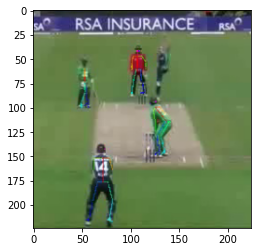

In [ ]:
image = frame[0][0].copy()
plt.imshow(image)

In [ ]:
# 이미지의 종류
str = "Activity :{}".format(text_predict)
# str을 출력할 이미지 좌표
org=(0,20) 
# 이미지 폰트
font=cv2.FONT_HERSHEY_PLAIN
# image에 str을 출력
cv2.putText(image,str,org,font, 1 ,(255,0, 0) , False)

array([[[0.08235294, 0.10980392, 0.07843138],
        [0.1882353 , 0.21960784, 0.18431373],
        [0.23529412, 0.2627451 , 0.24705882],
        ...,
        [0.15294118, 0.1764706 , 0.11372549],
        [0.1254902 , 0.14901961, 0.08627451],
        [0.09019608, 0.11372549, 0.05098039]],

       [[0.2784314 , 0.30980393, 0.27450982],
        [0.3647059 , 0.39607844, 0.3647059 ],
        [0.38431373, 0.4117647 , 0.39607844],
        ...,
        [0.1254902 , 0.14901961, 0.09019608],
        [0.14509805, 0.16862746, 0.10980392],
        [0.15686275, 0.18431373, 0.12156863]],

       [[0.4       , 0.42745098, 0.40392157],
        [0.46666667, 0.49411765, 0.4745098 ],
        [0.43529412, 0.4627451 , 0.44705883],
        ...,
        [0.09411765, 0.1254902 , 0.09019608],
        [0.13333334, 0.16470589, 0.12941177],
        [0.16862746, 0.2       , 0.16470589]],

       ...,

       [[0.3529412 , 0.4745098 , 0.23137255],
        [0.3529412 , 0.4745098 , 0.23137255],
        [0.35686275, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


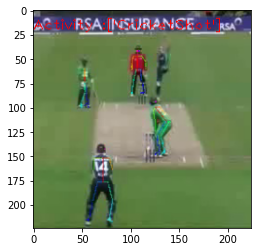

In [ ]:
plt.imshow(image)

In [ ]:
# 0으로 초기화된 [20,224,224,3 ] 배열 생성
images = np.zeros(shape=(10,224,224,3))
# X_test의 0번째 비디오
frame = X_test[0:1]
# 비디오  종류 예측
predict01 = model.predict(frame)
# 최고값이 있는 인덱스 조회
predict02 = np.argmax(predict01, axis=1)
# 이미지의 종류 조회
text_predict = le.classes_[predict02]
# 이미지의 종류
str = "Activity :{}".format(text_predict)
print("str = ", str)
for i in range(10):
    #frame 복사
    image = frame[0][i].copy()
    # str을 출력할 이미지 좌표
    org=(0,20) 
    # 이미지 폰트
    font=cv2.FONT_HERSHEY_PLAIN
    # image에 str을  출력
    cv2.putText(image,str,org,font, 1 ,(255,0, 0) , False)
    # images에 image 추가
    images[i] = image * 255

str =  Activity :['CricketShot']



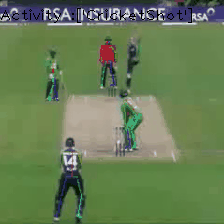

In [ ]:
# images를 정수로 변환
converted_images = images.astype(np.uint8)
# converted_images 를 animation.gif로 변환
imageio.mimsave("animation.gif", converted_images, fps=10)
# animation.gif 를 출력
embed.embed_file("animation.gif")

In [9]:
text_label = np.array(['CricketShot', 'Punch', 'TennisSwing'])

In [10]:
video_skeleton_cricket_shot = load_video('/content/skeleton_cricket_shot.mp4')
video_skeleton_punch = load_video('/content/skeleton_punch.mp4')
video_skeleton_tennis = load_video('/content/skeleton_tennis.mp4')

In [11]:
video_skeleton_cricket_shot = video_skeleton_cricket_shot.reshape(-1,20,224,224,3)
video_skeleton_punch = video_skeleton_punch.reshape(-1,20,224,224,3)
video_skeleton_tennis = video_skeleton_tennis.reshape(-1,20,224,224,3)

str =  Activity :['Punch']



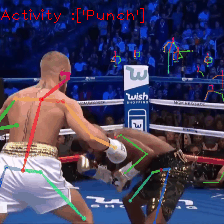

In [16]:
# 0으로 초기화된 [20,224,224,3 ] 배열 생성
images = np.zeros(shape=(20,224,224,3))
# X_test의 0번째 비디오
frame = video_skeleton_punch[0:1]
# 비디오  종류 예측
predict01 = model.predict(frame/255)
# 최고값이 있는 인덱스 조회
predict02 = np.argmax(predict01, axis=1)
# 이미지의 종류 조회
text_predict = text_label[predict02]
# 이미지의 종류
str = "Activity :{}".format(text_predict)
print("str = ", str)
for i in range(20):
    #frame 복사
    image = frame[0][i].copy()
    # str을 출력할 이미지 좌표
    org=(0,20) 
    # 이미지 폰트
    font=cv2.FONT_HERSHEY_PLAIN
    # image에 str을  출력
    cv2.putText(image,str,org,font, 1 ,(255,0, 0) , False)
    # images에 image 추가
    images[i] = image

# images를 정수로 변환
converted_images = images.astype(np.uint8)
# converted_images 를 animation.gif로 변환
imageio.mimsave("animation.gif", converted_images, fps=20)
# animation.gif 를 출력
embed.embed_file("animation.gif")

str =  Activity :['TennisSwing']



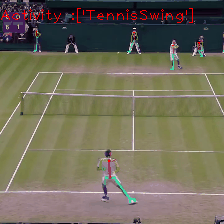

In [17]:
# 0으로 초기화된 [20,224,224,3 ] 배열 생성
images = np.zeros(shape=(20,224,224,3))
# X_test의 0번째 비디오
frame = video_skeleton_tennis[0:1]
# 비디오  종류 예측
predict01 = model.predict(frame/255)
# 최고값이 있는 인덱스 조회
predict02 = np.argmax(predict01, axis=1)
# 이미지의 종류 조회
text_predict = text_label[predict02]
# 이미지의 종류
str = "Activity :{}".format(text_predict)
print("str = ", str)
for i in range(20):
    #frame 복사
    image = frame[0][i].copy()
    # str을 출력할 이미지 좌표
    org=(0,20) 
    # 이미지 폰트
    font=cv2.FONT_HERSHEY_PLAIN
    # image에 str을  출력
    cv2.putText(image,str,org,font, 1 ,(255,0, 0) , False)
    # images에 image 추가
    images[i] = image

# images를 정수로 변환
converted_images = images.astype(np.uint8)
# converted_images 를 animation.gif로 변환
imageio.mimsave("animation.gif", converted_images, fps=20)
# animation.gif 를 출력
embed.embed_file("animation.gif")

str =  Activity :['TennisSwing']



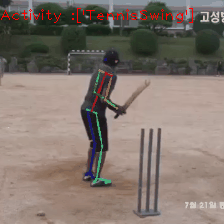

In [18]:
# 0으로 초기화된 [20,224,224,3 ] 배열 생성
images = np.zeros(shape=(20,224,224,3))
# X_test의 0번째 비디오
frame = video_skeleton_cricket_shot[0:1]
# 비디오  종류 예측
predict01 = model.predict(frame/255)
# 최고값이 있는 인덱스 조회
predict02 = np.argmax(predict01, axis=1)
# 이미지의 종류 조회
text_predict = text_label[predict02]
# 이미지의 종류
str = "Activity :{}".format(text_predict)
print("str = ", str)
for i in range(20):
    #frame 복사
    image = frame[0][i].copy()
    # str을 출력할 이미지 좌표
    org=(0,20) 
    # 이미지 폰트
    font=cv2.FONT_HERSHEY_PLAIN
    # image에 str을  출력
    cv2.putText(image,str,org,font, 1 ,(255,0, 0) , False)
    # images에 image 추가
    images[i] = image

# images를 정수로 변환
converted_images = images.astype(np.uint8)
# converted_images 를 animation.gif로 변환
imageio.mimsave("animation.gif", converted_images, fps=20)
# animation.gif 를 출력
embed.embed_file("animation.gif")